In [ ]:
# 由于没有时间安排习题课，将part1的答案直接提供，请需要学习的同学自行完成作业后校对
# Multi-head Attention是Transformer的核心模块之一，当前大部分公司AI岗位面试的常考题
import math
import torch
from torch import nn


In [2]:
import collections, re
import torch
from torch import nn
from torch.nn import functional as F
import math
def count_corpus(tokens):
    """统计词元的频率"""
    if len(tokens) == 0 or isinstance(tokens[0], list):
        tokens = [token for line in tokens for token in line]
    return collections.Counter(tokens)

class Vocab:
    def __init__(self, tokens=None, min_freq=0, reserved_tokens=None):
        if tokens is None:
            tokens = []
        if reserved_tokens is None:
            reserved_tokens = []
        counter = count_corpus(tokens)
        self._token_freqs = sorted(counter.items(), key=lambda x: x[1],
                                   reverse=True)
        self.idx_to_token = ['<unk>'] + reserved_tokens
        self.token_to_idx = {token: idx
                             for idx, token in enumerate(self.idx_to_token)}
        for token, freq in self._token_freqs:
            if freq < min_freq:
                break
            if token not in self.token_to_idx:
                self.idx_to_token.append(token)
                self.token_to_idx[token] = len(self.idx_to_token) - 1

    def __len__(self):
        return len(self.idx_to_token)

    def __getitem__(self, tokens):
        if not isinstance(tokens, (list, tuple)):
            return self.token_to_idx.get(tokens, self.unk)
        return [self.__getitem__(token) for token in tokens]

    def to_tokens(self, indices):
        if not isinstance(indices, (list, tuple)):
            return self.idx_to_token[indices]
        return [self.idx_to_token[index] for index in indices]

    @property
    def unk(self):  # 未知词元的索引为0
        return 0

    @property
    def token_freqs(self):
        return self._token_freqs


def tokenize(lines): # char level
    return [list(line) for line in lines]

def read_time_machine():
    with open('./data/timemachine.txt', 'r') as f:
        lines = f.readlines()
    return [re.sub('[^A-Za-z]+', ' ', line).strip().lower() for line in lines]

def load_corpus_time_machine(max_tokens=-1): 
    """返回时光机器数据集的词元索引列表和词表"""
    lines = read_time_machine()
    tokens = tokenize(lines)
    vocab = Vocab(tokens)
    # 因为时光机器数据集中的每个文本行不一定是一个句子或一个段落，
    # 所以将所有文本行展平到一个列表中
    corpus = [vocab[token] for line in tokens for token in line]
    if max_tokens > 0:
        corpus = corpus[:max_tokens]
    return corpus, vocab

corpus, vocab = load_corpus_time_machine()
import torch, random
def seq_data_iter_sequential(corpus, batch_size, num_steps):
    """使用顺序分区生成一个小批量子序列"""
    # 从随机偏移量开始划分序列
    offset = random.randint(0, num_steps)
    num_tokens = ((len(corpus) - offset - 1) // batch_size) * batch_size
    Xs = torch.tensor(corpus[offset: offset + num_tokens])
    Ys = torch.tensor(corpus[offset + 1: offset + 1 + num_tokens])
    Xs, Ys = Xs.reshape(batch_size, -1), Ys.reshape(batch_size, -1)
    num_batches = Xs.shape[1] // num_steps
    for i in range(0, num_steps * num_batches, num_steps):
        X = Xs[:, i: i + num_steps]
        Y = Ys[:, i: i + num_steps]
        yield X, Y
        
class SeqDataLoader:  
    """加载序列数据的迭代器"""
    def __init__(self, batch_size, num_steps, use_random_iter, max_tokens):
        self.data_iter_fn = seq_data_iter_sequential
        self.corpus, self.vocab = load_corpus_time_machine(max_tokens)
        self.batch_size, self.num_steps = batch_size, num_steps

    def __iter__(self):
        return self.data_iter_fn(self.corpus, self.batch_size, self.num_steps)

def load_data_time_machine(batch_size, num_steps,  
                           use_random_iter=False, max_tokens=10000):
    """返回时光机器数据集的迭代器和词表"""
    data_iter = SeqDataLoader(
        batch_size, num_steps, use_random_iter, max_tokens)
    return data_iter, data_iter.vocab


In [3]:
def sequence_mask(X, valid_len, value=0):
    """在序列中屏蔽不相关的项"""
    maxlen = X.size(1)
    mask = torch.arange((maxlen), dtype=torch.float32,
                        device=X.device)[None, :] < valid_len[:, None]
    X[~mask] = value
    return X

def masked_softmax(X, valid_lens):
    """通过在最后一个轴上掩蔽元素来执行softmax操作"""
    if valid_lens is None:
        return nn.functional.softmax(X, dim=-1)
    else:
        shape = X.shape
        if valid_lens.dim() == 1:
            valid_lens = torch.repeat_interleave(valid_lens, shape[1])
        else:
            valid_lens = valid_lens.reshape(-1)
        X = sequence_mask(X.reshape(-1, shape[-1]), valid_lens, value=-1e6)
        return nn.functional.softmax(X.reshape(shape), dim=-1)

class DotProductAttention(nn.Module):
    def __init__(self, dropout, **kwargs):
        super(DotProductAttention, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)

    def forward(self, queries, keys, values, valid_lens=None):
        d = queries.shape[-1]

        # 计算注意力分数，将结果除以 sqrt(d) 来标准化
        # hint: 使用 torch.bmm 或者 @运算 来进行批量矩阵乘法
        scores = torch.bmm(queries, keys.transpose(1,2)) / math.sqrt(d)

        # 掩蔽无效位置，对剩下位置计算softmax归一化后的注意力分数
        attention_weights = masked_softmax(scores, valid_lens)
        
        # 把注意力分数和对应的values相乘
        result = torch.bmm(self.dropout(attention_weights), values)
        return result
        
class MultiHeadAttention(nn.Module):
    """多头注意力"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 num_heads, dropout, bias=False, **kwargs):
        super(MultiHeadAttention, self).__init__(**kwargs)
        self.num_heads = num_heads
        self.attention = DotProductAttention(dropout)
        self.W_q = nn.Linear(query_size, num_hiddens, bias=bias)
        self.W_k = nn.Linear(key_size, num_hiddens, bias=bias)
        self.W_v = nn.Linear(value_size, num_hiddens, bias=bias)
        self.W_o = nn.Linear(num_hiddens, num_hiddens, bias=bias)


    #@save
    def forward(self, queries, keys, values, valid_lens):
        # queries，keys，values一开始的形状: (batch_size，L，num_hiddens)
        
        # 将q, k, v分别通过对应W_q, W_k, W_v
        queries = self.W_q(queries)
        keys = self.W_k(keys)
        values = self.W_v(values)
        
        # 切出num_heads个头，维度变成 (batch_size, L, num_heads, num_hiddens / num_heads)
        queries = queries.reshape(queries.shape[0], queries.shape[1], self.num_heads, -1)
        keys = keys.reshape(keys.shape[0], keys.shape[1], self.num_heads, -1)
        values = values.reshape(values.shape[0], values.shape[1], self.num_heads, -1)

        # 通过permute和reshape使维度变成 (batch_size * num_heads, L, num_hiddens / num_heads)
        # 此时，queries[i], keys[i], values[i] 表示特定batch_id & head_id下的qkv序列
        queries = queries.permute(0, 2, 1, 3)
        queries = queries.reshape(-1, queries.shape[2], queries.shape[3])  
        
        keys = keys.permute(0, 2, 1, 3)
        keys = keys.reshape(-1, keys.shape[2], keys.shape[3])
        
        values = values.permute(0, 2, 1, 3)
        values = values.reshape(-1, values.shape[2], values.shape[3])
        
        if valid_lens is not None:
            valid_lens = torch.repeat_interleave(
                valid_lens, repeats=self.num_heads, dim=0)
        output = self.attention(queries, keys, values, valid_lens) 
        
        # 此时output的形状是 (batch_size * num_heads, L, num_hiddens / num_heads)，把他恢复成 (batch_size，L，num_hiddens)
        output = output.reshape(-1, self.num_heads, output.shape[1], output.shape[2])
        output = output.permute(0, 2, 1, 3)
        output = output.reshape(output.shape[0], output.shape[1], -1)
        return self.W_o(output)


In [ ]:
# 测试一下效果
num_hiddens, num_heads = 100, 5
attention = MultiHeadAttention(num_hiddens, num_hiddens, num_hiddens,
                               num_hiddens, num_heads, 0.5)
attention.eval()
batch_size, num_queries = 2, 4
num_kvpairs, valid_lens = 6, torch.tensor([[1, 2, 3, 4], [1, 2, 3, 4]])
X = torch.ones((batch_size, num_queries, num_hiddens))
Y = torch.ones((batch_size, num_kvpairs, num_hiddens))
attention(X, Y, Y, valid_lens).shape # it should be torch.Size([2, 4, 100])

In [ ]:
class PositionWiseFFN(nn.Module):
    """基于位置的前馈网络"""
    def __init__(self, ffn_num_input, ffn_num_hiddens, ffn_num_outputs,
                 **kwargs):
        super(PositionWiseFFN, self).__init__(**kwargs)
        self.dense1 = nn.Linear(ffn_num_input, ffn_num_hiddens)
        self.relu = nn.ReLU()
        self.dense2 = nn.Linear(ffn_num_hiddens, ffn_num_outputs)

    def forward(self, X):
        return self.dense2(self.relu(self.dense1(X)))
    
class AddNorm(nn.Module):
    """残差连接后进行层规范化"""
    def __init__(self, normalized_shape, dropout, **kwargs):
        super(AddNorm, self).__init__(**kwargs)
        self.dropout = nn.Dropout(dropout)
        self.ln = nn.LayerNorm(normalized_shape)

    def forward(self, X, Y):
        return self.ln(self.dropout(Y) + X)
    
class PositionalEncoding(nn.Module):
    """Positional encoding.
    """
    def __init__(self, num_hiddens, dropout, max_len=1000):
        super(PositionalEncoding, self).__init__()
        self.dropout = nn.Dropout(dropout)
        # Create a long enough `P`
        self.P = torch.zeros((1, max_len, num_hiddens))
        X = torch.arange(max_len, dtype=torch.float32).reshape(
            -1, 1) / torch.pow(10000, torch.arange(
            0, num_hiddens, 2, dtype=torch.float32) / num_hiddens)
        self.P[:, :, 0::2] = torch.sin(X)
        self.P[:, :, 1::2] = torch.cos(X)

    def forward(self, X):
        X = X + self.P[:, :X.shape[1], :].to(X.device)
        return self.dropout(X)

In [ ]:
class DecoderBlock(nn.Module):
    """解码器块"""
    def __init__(self, key_size, query_size, value_size, num_hiddens,
                 norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
                 dropout, i, **kwargs):
        super(DecoderBlock, self).__init__(**kwargs)
        self.i = i
        self.attention = MultiHeadAttention(
            key_size, query_size, value_size, num_hiddens, num_heads, dropout)
        self.addnorm1 = AddNorm(norm_shape, dropout)
        self.ffn = PositionWiseFFN(ffn_num_input, ffn_num_hiddens, num_hiddens)
        self.addnorm2 = AddNorm(norm_shape, dropout)

    def forward(self, X, state):
        if state[self.i] is None:
            key_values = X
        else:
            key_values = torch.cat((state[self.i], X), axis=1)
        state[self.i] = key_values 
        if self.training:
            batch_size, num_steps, _ = X.shape
            dec_valid_lens = torch.arange(
                1, num_steps + 1, device=X.device).repeat(batch_size, 1)
        else:
            dec_valid_lens = None

        # 自注意力
        X = self.attention(X, key_values, key_values, dec_valid_lens)
        Y = self.addnorm1(X, X)
        
        return self.addnorm2(Y, self.ffn(Y)), state

In [ ]:
class TransformerDecoderOnly(nn.Module):
    def __init__(self, vocab_size, key_size, query_size, value_size,
                 num_hiddens, norm_shape, ffn_num_input, ffn_num_hiddens,
                 num_heads, num_layers, dropout, **kwargs):
        super(TransformerDecoderOnly, self).__init__(**kwargs)
        self.num_hiddens = num_hiddens
        self.num_layers = num_layers
        self.embedding = nn.Embedding(vocab_size, num_hiddens)
        self.pos_encoding = PositionalEncoding(num_hiddens, dropout)
        self.blks = nn.Sequential()
        for i in range(num_layers):
            self.blks.add_module("block"+str(i),
                DecoderBlock(key_size, query_size, value_size, num_hiddens,
                             norm_shape, ffn_num_input, ffn_num_hiddens,
                             num_heads, dropout, i))
        self.dense = nn.Linear(num_hiddens, vocab_size)
                
    def init_state(self, *args):
        return [None] * self.num_layers
    
    def forward(self, X, state=None):
        # 输入X形状: (batch_size, seq_length)
        # 对每个token进行embedding并加上位置编码
        X = self.pos_encoding(self.embedding(X) * math.sqrt(self.num_hiddens))

        for i, blk in enumerate(self.blks):
            X, state = blk(X, state)
        
        return self.dense(X), state


In [ ]:
sz = 64
num_hiddens, num_layers, dropout = sz, 2, 0.1
ffn_num_input, ffn_num_hiddens, num_heads = sz, sz * 2, 16
key_size, query_size, value_size = sz, sz, sz
norm_shape = [sz]

batch_size, num_steps = 32, 35
train_iter, vocab = load_data_time_machine(batch_size, num_steps)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = TransformerDecoderOnly(len(vocab), key_size, query_size, value_size, num_hiddens,
    norm_shape, ffn_num_input, ffn_num_hiddens, num_heads,
    num_layers, dropout).to(device)

In [ ]:
def predict(prefix, num_preds, net, vocab, device):
    input_ids = [vocab[x] for x in prefix]
    X = torch.tensor(input_ids, device=device).unsqueeze(0)
    state = net.init_state()
    output_seq = prefix
    output_tokens = []
    for _ in range(num_preds):
        Y, state = net(X, state)
        Y = Y[:, -1, :]
        X = Y.argmax(dim=-1)
        pred = X.squeeze(dim=0).type(torch.int32).item()
        output_tokens.append(pred)
        output_seq += vocab.to_tokens(pred)
    print(output_tokens)
    return output_seq

epoch: 49, ppl: 4.781864540170288
[1, 4, 1, 4, 1, 4, 1, 13, 4, 6, 11, 1, 9, 4, 22, 2, 3, 7, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4, 1, 4]
The Time Traveller a a a mand haveto a a a a a a a a a a a a a a a a
epoch: 99, ppl: 5.093928062327583
[2, 10, 1, 4, 12, 19, 1, 3, 9, 2, 1, 20, 8, 2, 11, 4, 19, 1, 5, 6, 18, 1, 3, 9, 7, 3, 9, 5, 13, 2, 10, 1, 4, 6, 1, 3, 9, 2, 1, 4, 3, 9, 2, 1, 3, 9, 2, 1, 3, 9]
The Time Travellerer aly the pseday ing thothimer an the athe the th
epoch: 149, ppl: 4.760249637735838
[1, 4, 1, 8, 7, 16, 1, 8, 7, 14, 10, 1, 11, 5, 1, 16, 10, 1, 8, 15, 2, 5, 1, 16, 7, 10, 1, 4, 1, 4, 1, 4, 1, 16, 7, 10, 1, 8, 7, 10, 1, 8, 7, 10, 1, 8, 7, 13, 1, 8]
The Time Traveller a sof sour di fr scei for a a a for sor sor som s
epoch: 199, ppl: 4.933304932927046
[1, 18, 7, 16, 1, 3, 9, 2, 1, 22, 2, 10, 7, 16, 1, 9, 2, 1, 9, 2, 1, 9, 2, 1, 9, 2, 1, 9, 2, 1, 9, 2, 1, 18, 10, 2, 1, 7, 13, 2, 2, 2, 2, 2, 1, 7, 16, 3, 9, 2]
The Time Travell

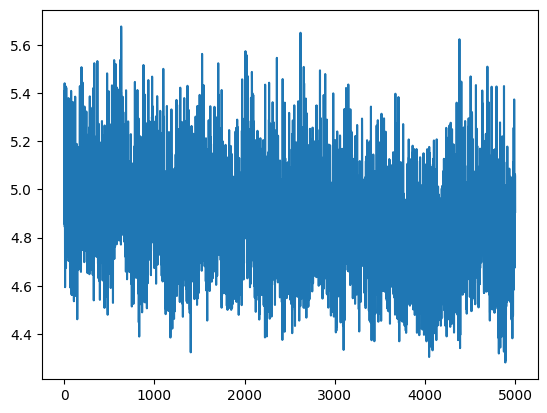

In [35]:
def train_epoch(net, train_iter, loss, optimizer, device):
    metric = [0, 0]
    state = None
    for X, Y in train_iter:
        state = net.init_state()
        y = Y.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        y_hat = y_hat.view(-1, y_hat.shape[-1])
        l = loss(y_hat, y.long()).mean()
        
        optimizer.zero_grad()
        l.backward()
        optimizer.step()
        
        metric[0] += l * y.numel()
        metric[1] += y.numel()
        
    return math.exp(metric[0] / metric[1])

def train(net, train_iter, vocab, lr, num_epochs, device):
    loss = nn.CrossEntropyLoss()
    optimizer = torch.optim.AdamW(net.parameters(), lr)
    cur_predict = lambda prefix: predict(prefix, 50, net, vocab, device)
    ppl_list = []
    for epoch in range(num_epochs):
        ppl = train_epoch(
            net, train_iter, loss, optimizer, device)
        ppl_list.append(ppl)
        if (epoch + 1) % 50 == 0:
            print(f'epoch: {epoch}, ppl: {ppl}')
            net.eval()
            with torch.no_grad():
                print(cur_predict('The Time Traveller'))
            net.train()
            
    print(cur_predict('The Time Traveller'))
    return ppl_list
lr, num_epochs = 0.01, 5000
ppl_list = train(model, train_iter, vocab, lr, num_epochs, device)
from matplotlib import pyplot as plt
plt.plot(ppl_list)